In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import typing

from IPython.display import display, Markdown

from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy  # type: ignore
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import DEFAULT_COLORMAP, DEFAULT_BAR_KWARGS, DEFAULT_TEXT_KWARGS, DEFAULT_YLIM, plot_prettify, filter_and_group, save_plot  # type: ignore


In [3]:
PAPER_FIGURE_DIR = '/Users/guydavidson/projects/Relation-Categorization-Journal-Paper/figures'

In [4]:
USE_LARGER_RESUTLS = False
USE_FLAPLESS_RESULTS = False

FILE_PATTERN = 'c_s_v4*.csv'
DF_SAVE_PATH = '../containment_support_outputs/dataframes/containment_support_df.csv'
LOAD_FROM_SCRATCH = False

CORRECT_KEY = 'containment_high_containment_cos'
INCORRECT_KEYS = ['containment_behind_cos', 'containment_far_behind_cos', 'containment_support_cos']
ORDERED_COLUMNS = ['full_model_name', 'model', 'training', 'flip', 'dino', 'n_target_types', 
        'configuration_index', 'example_index', 'reference_object', 'target_object', 'seed', 'unpooled_output',
        'containment_high_containment_cos', 'containment_behind_cos', 'containment_far_behind_cos',
        'containment_support_cos', 'high_containment_behind_cos', 'high_containment_far_behind_cos',
        'high_containment_support_cos', 'behind_far_behind_cos', 'behind_support_cos', 'far_behind_support_cos',
        'high_containment_vs_behind', 'high_containment_vs_behind_diff',
        'high_containment_vs_behind_ratio', 'high_containment_vs_far_behind',
        'high_containment_vs_far_behind_diff',
        'high_containment_vs_far_behind_ratio', 'high_containment_vs_support',
        'high_containment_vs_support_diff', 'high_containment_vs_support_ratio',
        'behind_similar', 'far_behind_similar', 'support_similar',
        'high_containment_similar']
TARGET_OBJECTS = ['BeachBall', 'Knight', 'Lego', 'Pineapple', 'PingPong', 'Robot', 'RubberDuck', 'Teddy',]


def load_and_join_dataframes(folder: str, files: typing.Union[str, typing.Sequence[str]]) -> pd.DataFrame:
    if isinstance(files, str):
        files = glob.glob(os.path.join(folder, files))
        print(files)
        
    dfs = []
    for file_name in files:
        df = pd.read_csv(os.path.join(folder, file_name))
        df = df.assign(n_target_types=np.where(df.target_object == df.habituation_target_object, 1, 2))
        dfs.append(df)

    df = pd.concat(dfs)
    df.reset_index(drop=True, inplace=True)
    return df


def load_df(folder: str, file: str,) -> pd.DataFrame:
    return pd.read_csv(os.path.join(folder, file))

def parse_model_name(df: pd.DataFrame) -> pd.DataFrame:
    new_series_values = defaultdict(list)

    for name in df.model:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['full_model_name'].append(name)  # type: ignore
        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


def _key_middle(key: str) -> str:
    return '_'.join(key.split('_')[1:-1])


def _key_to_similarity_key(key: str) -> str:
    return f'{_key_middle(key)}_similar'


def pairwise_correct_key(correct_key: str, incorrect_key: str, suffix: str = '') -> str:
    return f'{_key_middle(correct_key)}_vs_{_key_middle(incorrect_key)}{suffix}'


def evaluate_accuracy(df: pd.DataFrame, correct_key: str = CORRECT_KEY, 
    incorrect_keys: typing.Sequence[str] = INCORRECT_KEYS) -> pd.DataFrame:
    max_similarities = {_key_to_similarity_key(key): [] for key in incorrect_keys}
    max_similarities[_key_to_similarity_key(correct_key)] = []

    pairwise_comparisons = {pairwise_correct_key(correct_key, key, suffix): [] for key in incorrect_keys
        for suffix in ('', '_diff', '_ratio')}

    for _, row in df.iterrows():    
        row = row[[correct_key] + list(incorrect_keys)]
        max_value = row.max()

        correct_val = row[correct_key]
        max_similarities[_key_to_similarity_key(correct_key)].append(correct_val == max_value)
        
        for incorrect_key in incorrect_keys:
            incorrect_val = row[incorrect_key]
            max_similarities[_key_to_similarity_key(incorrect_key)].append(incorrect_val == max_value)

            pairwise_comparisons[pairwise_correct_key(correct_key, incorrect_key)].append(correct_val >= incorrect_val)
            pairwise_comparisons[pairwise_correct_key(correct_key, incorrect_key, '_diff')].append(correct_val - incorrect_val)
            pairwise_comparisons[pairwise_correct_key(correct_key, incorrect_key, '_ratio')].append(correct_val / incorrect_val)

    return df.assign(**pairwise_comparisons, **max_similarities)


def full_load_pipeline(folder: str, file_pattern: str, ignore_list: typing.Sequence[str] = tuple()):
    df = load_and_join_dataframes(folder, file_pattern)
    # df = load_df(folder, file)
    df.drop(columns=[df.columns[0]], inplace=True)  # type: ignore
    df = parse_model_name(df)
    # df = add_target_object_field(df)
    df = evaluate_accuracy(df)
    df = df[ORDERED_COLUMNS]
    return df


if LOAD_FROM_SCRATCH:
    combined_df = full_load_pipeline('../containment_support_outputs', FILE_PATTERN)  #  ignore_list=IGNORE_SMALLER_LIST)
    combined_df.to_csv(DF_SAVE_PATH, index=False)
else:
    combined_df = pd.read_csv(DF_SAVE_PATH)
    


print(combined_df.shape)
combined_df.head()

(262144, 35)


/Users/guydavidson/opt/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,full_model_name,model,training,flip,dino,n_target_types,configuration_index,example_index,reference_object,target_object,...,high_containment_vs_far_behind,high_containment_vs_far_behind_diff,high_containment_vs_far_behind_ratio,high_containment_vs_support,high_containment_vs_support_diff,high_containment_vs_support_ratio,behind_similar,far_behind_similar,support_similar,high_containment_similar
0,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,0,Basket,BeachBall,...,True,0.007056,1.009127,True,0.022993,1.030366,False,False,False,True
1,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,1,Basket,Knight,...,True,0.033865,1.040573,True,0.066863,1.083405,False,False,False,True
2,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,2,Basket,Lego,...,True,0.009470,1.011536,True,0.046757,1.059669,False,False,False,True
3,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,3,Basket,Pineapple,...,True,0.036096,1.045683,True,0.062260,1.081494,False,False,False,True
4,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,4,Basket,PingPong,...,False,-0.001558,0.998185,True,0.050519,1.062632,False,True,False,False


In [5]:
stimuli_match_df = pd.read_csv('../containment_support_outputs/dataframes/containment_support_stimuli_match_df.csv')
display(stimuli_match_df.head())
combined_df = combined_df.join(stimuli_match_df, how='left', rsuffix='_match')
print(combined_df.shape)
combined_df.head()

,configuration_index,example_index,matched_behind,matched_behind_high
0,0,0,True,True
1,0,1,True,True
2,0,2,True,True
3,0,3,True,True
4,0,4,True,True


(262144, 39)


,full_model_name,model,training,flip,dino,n_target_types,configuration_index,example_index,reference_object,target_object,...,high_containment_vs_support_diff,high_containment_vs_support_ratio,behind_similar,far_behind_similar,support_similar,high_containment_similar,configuration_index_match,example_index_match,matched_behind,matched_behind_high
0,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,0,Basket,BeachBall,...,0.022993,1.030366,False,False,False,True,0,0,True,True
1,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,1,Basket,Knight,...,0.066863,1.083405,False,False,False,True,0,1,True,True
2,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,2,Basket,Lego,...,0.046757,1.059669,False,False,False,True,0,2,True,True
3,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,3,Basket,Pineapple,...,0.062260,1.081494,False,False,False,True,0,3,True,True
4,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,4,Basket,PingPong,...,0.050519,1.062632,False,True,False,False,0,4,True,True


In [6]:
(combined_df.configuration_index == combined_df.configuration_index_match).all(), (combined_df.example_index == combined_df.example_index_match).all()

(True, True)

In [7]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
    'triplet_generator': ['diagonal', 'equidistant'],
    'same_horizontal_half': [True, False],
    'condition': ['different_shapes', 'split_text', 'random_color'],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword

SEED_COLORMAP = plt.get_cmap('Set3')

DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
            'vitb14': DEFAULT_COLORMAP(2),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        },
        seed={
            seed: SEED_COLORMAP(seed - 33)
            for seed in range(33, 43)
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    ),
    marker=dict(
        # if we marker by training
        training={
            'random': 'X',
            'saycam(S)': 'o',
            'ImageNet': 's',
            'saycam(S)-flip': 'o',
        },
        dino={
            'ImageNet': 's',
            'saycam(S)': 'o',
        }
    ),
    edgecolor=dict(
        n_target_types={
            1: 'none',
            2: 'black',
        },
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)

DEFAULT_LINE_KWARGS = dict(marker='.', linestyle='-')

FILTER_DICT_DEFAULT_VALUES = dict(
    rotate_angle=0,
    transpose=False,
    same_relation_target_distance_ratio='1.0',
    unpooled_output=False,
)

FILTER_DICT_SUBSTITUTE_KEYS = dict(
    rotate_angle=['effective_angle', 'angle_from_horizontal'],
)


DEFAULT_YALBELS = defaultdict(lambda: 'Accuracy', 
    cos_ratio='Cosine similarity ratio',
    cos_diff='Cosine similarity difference',
)

FilterDict = typing.Dict[str, typing.Union[None, int, float, str, typing.Sequence[str]]]


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.Sequence[str],
    mean: pd.core.groupby.SeriesGroupBy,  # type: ignore
    std: pd.core.groupby.SeriesGroupBy,   # type: ignore
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
):

    key = tuple(key)
    m = mean.loc[key]

    if remap_range is not None:
        m = m * (remap_range[1] - remap_range[0]) + remap_range[0]

    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    # TODO: above bar texts would go here, if they exist
    return x + bar_width 


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs,
                        remap_range=remap_range)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs,
                    remap_range=remap_range)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def line_plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):

    group_values = orders_by_field[group_bars_by]    
    x_locs = np.arange(len(group_values))
    for color_by_value in orders_by_field[color_bars_by]:
        means = [mean.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]
        stds = [std.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]

        if remap_range is not None:
            means = [m * (remap_range[1] - remap_range[0]) + remap_range[0] for m in means]

        if plot_std:
            ax.errorbar(x_locs, means, stds, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
        else:
            ax.plot(x_locs, means, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
    
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_locs)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def _add_ylabel_to_ax(ax: matplotlib.axes.Axes, ylabel: typing.Union[str, typing.Sequence[typing.Dict[str, typing.Any]]], 
    text_kwargs: typing.Dict[str, typing.Any]):

    if isinstance(ylabel, str):
        ax.set_ylabel(ylabel, **text_kwargs)

    elif isinstance(ylabel, (list, tuple)):
        multiple_label_kwargs = copy.copy(text_kwargs)
        multiple_label_kwargs['fontsize'] -= 4

        for ylabel_part in ylabel:
            ax.text(**ylabel_part, transform=ax.transAxes, **multiple_label_kwargs)

    else:
        print(f'Unrecognized ylabel: {ylabel}')


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    marker_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    markersize: int = 15,):

    patches = []

    if legend_ncol is None:
        legend_ncol = 1

    if legend_kwargs is None:
        legend_kwargs = {}

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if marker_by is not None:
        for marker_by_value in orders_by_field[marker_by]:
            marker_kwargs = dict(marker=plot_style_by_field['marker'][marker_by][marker_by_value],
                markersize=markersize)
            patches.append(matplotlib.lines.Line2D([], [], **marker_kwargs, linestyle='None', color='black',
                label=plot_prettify(marker_by_value, marker_by)))

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=legend_ncol, 
            fontsize=text_kwargs['fontsize'] - 4, **legend_kwargs)

def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Union[None, str, typing.Sequence[str]] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    plot_field: str = 'acc_mean',
    compute_std: bool = False,
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, # type: ignore
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Any] = DEFAULT_BAR_KWARGS,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: typing.Union[None, str, typing.List[str]] = None,
    ylabel_per_ax: bool = False,
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    panel_title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    line_plot: bool = False,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    if panel_title_kwargs is None:
        panel_title_kwargs = {}
    if 'fontsize' not in panel_title_kwargs:
        panel_title_kwargs['fontsize'] = text_kwargs['fontsize'] + 4

    group_by_fields = [group_bars_by, color_bars_by]

    # if panel_by is a list, it's a series of metrics to panel_by
    if panel_by is not None and isinstance(panel_by, str):
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    if line_plot and hatch_bars_by is not None:
        raise ValueError(f'Cannot plot line plot with hatch bars by, received: {hatch_bars_by}')

    if ylabel is None:
        ylabel = DEFAULT_YALBELS[plot_field]

    if ylabel_per_ax:
        if panel_by is None:
            raise ValueError(f'Must provide panel_by (received {panel_by}) if ylabel_per_ax is True')

        if len(ylabel) != np.product(layout):
            raise ValueError(f'Must provide ylabel with length equal to product of layout (received {layout}) if ylabel_per_ax is True')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    if panel_by is not None and not isinstance(panel_by, str):
        panel_by_values = []
        for metric in panel_by:
            mean = grouped_df[metric].mean()
            std = grouped_df[metric].std()
            if sem:
                std /= np.sqrt(grouped_df[metric].count())  # type: ignore

            panel_by_values.append((mean, std))

        mean = panel_by_values[0][0]
    
    else:
        mean = grouped_df[plot_field].mean()

        if compute_std:
            std = grouped_df[plot_field].std()
            if sem:
                std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore
        
        else:
            if sem:
                std = grouped_df.acc_sem.mean()
            else:
                std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    fig = None
    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if isinstance(panel_by, str) and np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')
            
            if not isinstance(panel_by, str) and np.prod(layout) != len(panel_by):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        if line_plot:
            line_plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, 
                remap_range, add_chance_hline, y_chance,
                global_line_kwargs, text_kwargs, 
                ylim, ylabel)

        else:
            plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, hatch_bars_by,
                bar_width, bar_group_spacing, 
                remap_range, add_chance_hline, y_chance,
                global_bar_kwargs, text_kwargs, 
                ylim, ylabel)

        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by,  # type: ignore
            text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles, **title_kwargs)  # type: ignore

    else:
        n_rows, n_cols = layout  # type: ignore
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        if isinstance(panel_by, str):
            panel_iter = [(mean[panel_value], std[panel_value], plot_prettify(panel_value, panel_by)) for panel_value in orders_by_field[panel_by]]  # type: ignore

        else:
            panel_iter = [(*panel_by_values[i], panel_metric) for i, panel_metric in enumerate(panel_by)]  # type: ignore


        for i, (panel_mean, panel_std, panel_title) in enumerate(panel_iter):
            panel_ax = ax[i]  # type: ignore

            ax_ylabel = ylabel if not ylabel_per_ax else ylabel[i]

            if line_plot:
                line_plot_single_panel(panel_ax, panel_mean, panel_std,
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, 
                    remap_range, add_chance_hline, y_chance,
                    global_line_kwargs, text_kwargs, 
                    ylim, ax_ylabel if (i % n_cols == 0) or ylabel_per_ax else '')

            else:
                plot_single_panel(panel_ax, panel_mean, panel_std, 
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, hatch_bars_by,
                    bar_width, bar_group_spacing, 
                    remap_range, add_chance_hline, y_chance,
                    global_bar_kwargs, text_kwargs, 
                    ylim, ax_ylabel if (i % n_cols == 0) or ylabel_per_ax else '')

            if i == legend_ax_index:
                add_legend_to_ax(panel_ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
                    text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

            if panel_titles is not None:
                panel_title = panel_titles[i]
                
            panel_ax.set_title(panel_title, **panel_title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        if fig is not None: fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()

In [8]:
PLOT_FIELD = 'plot_field'

DEFAULT_SCATTER_KWARGS = dict(
    s=300,
    alpha=0.75,
)

DEFAULT_SCATTER_LINE_KWARGS = dict(
    linewidth=2,
    alpha=0.5,
)


def add_single_pair_to_ax(ax: plt.Axes, pair_means: pd.Series, pair_stds: typing.Optional[pd.Series],
    compare_by_values: typing.Sequence[typing.Union[str, int]], plot_field: typing.Union[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_by: str, marker_by: str, edgecolor_by: typing.Optional[str],
    color_by_value: str, marker_by_value: typing.Union[str, typing.Sequence[str]], edgecolor_by_value: typing.Optional[str],
    global_scatter_kwargs: typing.Dict[str, typing.Any],
    global_line_kwargs: typing.Dict[str, typing.Any],):

    x_values = np.arange(len(compare_by_values))
    y_values = [pair_means[compare_by_value] for compare_by_value in compare_by_values]

    color = plot_style_by_field['color'][color_by][color_by_value]
    
    edgecolor = plot_style_by_field['edgecolor'][edgecolor_by][edgecolor_by_value] if edgecolor_by is not None else None  # type: ignore

    if isinstance(marker_by_value, str):
        marker = plot_style_by_field['marker'][marker_by][marker_by_value]
        ax.scatter(x_values, y_values, color=color, marker=marker, edgecolor=edgecolor, **global_scatter_kwargs)
        ax.plot(x_values, y_values, color=color, **global_line_kwargs)
    
    else:
        for i, mbv in enumerate(marker_by_value):
            marker = plot_style_by_field['marker'][marker_by][mbv]
            ax.scatter(x_values[i], y_values[i], color=color, marker=marker, edgecolor=edgecolor, **global_scatter_kwargs)
        
        ax.plot(x_values, y_values, color=color, **global_line_kwargs)

    if pair_stds is not None:
        y_stds = [pair_stds[compare_by_value] for compare_by_value in compare_by_values]
        ax.errorbar(x_values, y_values, y_stds, color=color, **global_line_kwargs)


def paired_scatter_plot(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: FilterDict,
    compare_by: str, 
    color_by: str, 
    marker_by: str,
    edgecolor_by: typing.Optional[str] = None,
    filter_dict_default_values: typing.Dict[str, typing.Union[int, float, str, typing.Sequence[str]]] = FILTER_DICT_DEFAULT_VALUES,
    filter_dict_substitute_keys: typing.Dict[str, typing.Sequence[str]] = FILTER_DICT_SUBSTITUTE_KEYS,
    plot_std: bool = True,
    plot_field: typing.Union[str, typing.List[str]] = 'same_similar',
    compute_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # how to plot arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, 
    ax: typing.Optional[plt.Axes] = None,
    global_scatter_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_KWARGS,
    global_line_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    xlim: typing.Optional[typing.Tuple[float, float]] = None,
    ylim: typing.Optional[typing.Tuple[float, float]] = None,
    xlabel: typing.Optional[str] = None,
    ylabel: typing.Optional[str] = 'Accuracy',
    xticklabels: typing.Optional[typing.Sequence[str]] = None,
    title: typing.Optional[str] = None,
    add_chance_hline: bool = True,
    add_legend: bool = True,
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    legend_marker_by: bool = True,
    ):

    if global_scatter_kwargs is None:
        global_scatter_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [color_by, marker_by]
    if compare_by in group_by_fields:  # if it overlaps with another field, it should be last
        group_by_fields.remove(compare_by)
    
    if compare_by != PLOT_FIELD:
        group_by_fields.append(compare_by)
    
    if edgecolor_by is not None:
        group_by_fields.insert(-1, edgecolor_by)

    for default_value_key in filter_dict_default_values:
        if default_value_key not in filter_dict and default_value_key not in group_by_fields and default_value_key in df.columns:
            if default_value_key not in filter_dict_substitute_keys or not any([substitute_key in filter_dict or substitute_key in group_by_fields for substitute_key in filter_dict_substitute_keys[default_value_key]]):
                filter_dict[default_value_key] = filter_dict_default_values[default_value_key]

    print(f'Filtering and grouping by: {group_by_fields} with filter_dict: {filter_dict}')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    mean = grouped_df[plot_field].mean()

    if not isinstance(plot_field, str):
        compute_std = True

    if compute_std:
        std = grouped_df[plot_field].std()
        if sem:
            std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore

    else:
        if sem:
            std = grouped_df.acc_sem.mean()
        else:
            std = grouped_df.acc_std.mean()

    if ax is None:
        ax = plt.gca()

    ax = typing.cast(plt.Axes, ax)

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            new_orders_by_field = orders_by_field[field][:]
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    new_orders_by_field.remove(order_value)
            
            orders_by_field[field] = new_orders_by_field

    if compare_by == PLOT_FIELD:
        orders_by_field[compare_by] = plot_field

    for color_by_value in orders_by_field[color_by]:
        if marker_by == compare_by:
            key_prefix = (color_by_value,)
            add_single_pair_to_ax(
                ax, mean.loc[key_prefix], std.loc[key_prefix] if plot_std else None, 
                orders_by_field[compare_by], plot_field,
                plot_style_by_field, color_by, marker_by, edgecolor_by,
                color_by_value, orders_by_field[marker_by], None, global_scatter_kwargs, global_line_kwargs
            )

        else:
            for marker_by_value in orders_by_field[marker_by]:
                if edgecolor_by is not None:
                    for edgecolor_by_value in orders_by_field[edgecolor_by]:
                        key_prefix = (color_by_value, marker_by_value, edgecolor_by_value)
                        add_single_pair_to_ax(
                            ax, mean.loc[key_prefix], std.loc[key_prefix] if plot_std else None, 
                            orders_by_field[compare_by], plot_field,
                            plot_style_by_field, color_by, marker_by, edgecolor_by,
                            color_by_value, marker_by_value, edgecolor_by_value, global_scatter_kwargs, global_line_kwargs
                        )

                else:
                    key_prefix = (color_by_value, marker_by_value)
                    add_single_pair_to_ax(
                        ax, mean.loc[key_prefix], std.loc[key_prefix] if plot_std else None, 
                        orders_by_field[compare_by], plot_field,
                        plot_style_by_field, color_by, marker_by, edgecolor_by,
                        color_by_value, marker_by_value, None, global_scatter_kwargs, global_line_kwargs
                    )

    if xlim is not None:
        ax.set_xlim(*xlim)

    if ylim is not None:
        ax.set_ylim(*ylim)

    if add_chance_hline:
        xlim = ax.get_xlim()
        y_chance = 0.5
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', color='black', **global_line_kwargs)
        ax.set_xlim(*xlim)

    if xticklabels is None:
        xticklabels = [plot_prettify(val, field_name=compare_by) for val in orders_by_field[compare_by]]  # type: ignore

    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    ax.tick_params(axis='both', which='both', labelsize=text_kwargs['fontsize'] - 4)
    if xlabel is not None:
        ax.set_xlabel(xlabel, **text_kwargs)
    else:
        ax.set_xlabel(plot_prettify(compare_by), **text_kwargs)
    if ylabel is not None:
        _add_ylabel_to_ax(ax, ylabel, text_kwargs)

    if title is not None:
        ax.set_title(title, **title_kwargs)

    if add_legend:
        legend_text_kwargs = copy.deepcopy(text_kwargs)
        legend_text_kwargs['fontsize'] = legend_text_kwargs['fontsize'] - 4
        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, 
            color_by, None, marker_by if legend_marker_by else None, 
            legend_text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)


DEFAULT_PANEL_MARKER_LOCATION = (1.0, 0.95)
def default_panel_marker_formatter(index: int):
    return f'({chr(ord("A") + index)})'


def multiple_paired_scatter_plots(df: pd.DataFrame, 
    # new arguments for the multiple version
    dict_by_panel: typing.Sequence[dict],
    *,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    add_panel_markers: bool = True,
    panel_marker_location: typing.Tuple[float, float] = DEFAULT_PANEL_MARKER_LOCATION,
    panel_marker_formatter: typing.Callable[[int], str] = default_panel_marker_formatter,
    panel_marker_increment: int = 0,
    # what and how to plot arguments for the single version
    filter_dict_default_values: typing.Dict[str, typing.Union[int, float, str, typing.Sequence[str]]] = FILTER_DICT_DEFAULT_VALUES,
    filter_dict_substitute_keys: typing.Dict[str, typing.Sequence[str]] = FILTER_DICT_SUBSTITUTE_KEYS,
    plot_std: bool = True,
    plot_field: typing.Union[str, typing.List[str]] = 'same_similar',
    compute_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # how to plot arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, 
    global_scatter_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_KWARGS,
    global_line_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = DEFAULT_SCATTER_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    xlim: typing.Optional[typing.Tuple[float, float]] = None,
    ylim: typing.Optional[typing.Tuple[float, float]] = None,
    xlabel: typing.Optional[str] = None,
    ylabel: str = 'Accuracy',
    xticklabels: typing.Optional[typing.Sequence[str]] = None,
    sup_title: typing.Optional[str] = None,
    add_chance_hline: bool = True,
    add_legend: bool = True,
    legend_ax_index: int = 0,
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    legend_marker_by: bool = True,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
):
    
    if layout is None:
        layout = (1, len(dict_by_panel),)

    if figsize is None:
        figsize = (layout[1] * 5, layout[0] * 7)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, panel_dict in enumerate(dict_by_panel):
        ax = axes[i]
        paired_scatter_plot(
            df, ax=ax,
            filter_dict=panel_dict['filter_dict'], compare_by=panel_dict['compare_by'], color_by=panel_dict['color_by'],
            marker_by=panel_dict['marker_by'], edgecolor_by=panel_dict['edgecolor_by'],
            filter_dict_default_values=filter_dict_default_values, filter_dict_substitute_keys=filter_dict_substitute_keys,
            plot_std=plot_std, plot_field=panel_dict.get('plot_field', plot_field),
            compute_std=compute_std, sem=sem, remap_range=remap_range, orders_by_field=orders_by_field,
            plot_style_by_field=plot_style_by_field, global_scatter_kwargs=global_scatter_kwargs, global_line_kwargs=global_line_kwargs,
            text_kwargs=text_kwargs, title_kwargs=title_kwargs, xlim=xlim, ylim=ylim, 
            xlabel=panel_dict.get('xlabel', xlabel), 
            ylabel=ylabel if i == 0 else None, 
            xticklabels=panel_dict.get('xticklabels', xticklabels),
            title=panel_dict['title'], add_chance_hline=add_chance_hline, 
            add_legend=add_legend and ((i == legend_ax_index) or (legend_ax_index == -1)), 
            legend_loc=legend_loc, legend_ncol=legend_ncol, legend_kwargs=legend_kwargs, legend_marker_by=legend_marker_by,
        )

        if add_panel_markers:
            ax.text(*panel_marker_location, panel_marker_formatter(i + panel_marker_increment), transform=ax.transAxes, **text_kwargs)
    
    if sup_title is not None:
        fig.suptitle(sup_title, **title_kwargs)

    if subplot_adjust_params is not None:
        fig.subplots_adjust(**subplot_adjust_params)

    fig.align_labels()

    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()


In [9]:
DEFAULT_RELEVANT_FIELDS = (CORRECT_KEY, *INCORRECT_KEYS, 'correct', 'cos_ratio')

def compare_df_group_and_filter(first_df: pd.DataFrame, second_df: pd.DataFrame,
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    relevant_fields: typing.Sequence[str] = DEFAULT_RELEVANT_FIELDS,
):
    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    relevant_fields = list(relevant_fields)

    first_grouped_df = filter_and_group(first_df, filter_dict, group_by_fields)
    first_mean = first_grouped_df.mean()

    display(Markdown('## First dataframe'))
    display(Markdown('### Mean:'))
    display(first_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(first_grouped_df.std()[relevant_fields])

    second_grouped_df = filter_and_group(second_df, filter_dict, group_by_fields)
    second_mean = second_grouped_df.mean()

    display(Markdown('## Second dataframe'))
    display(Markdown('### Mean:'))
    display(second_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(second_grouped_df.std()[relevant_fields])
    
    return first_mean[relevant_fields] - second_mean[relevant_fields]

    

Filtering and grouping by: ['model', 'training'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'unpooled_output': False}
Filtering and grouping by: ['model', 'dino'] with filter_dict: {'training': 'DINO', 'flip': None, 'unpooled_output': False}


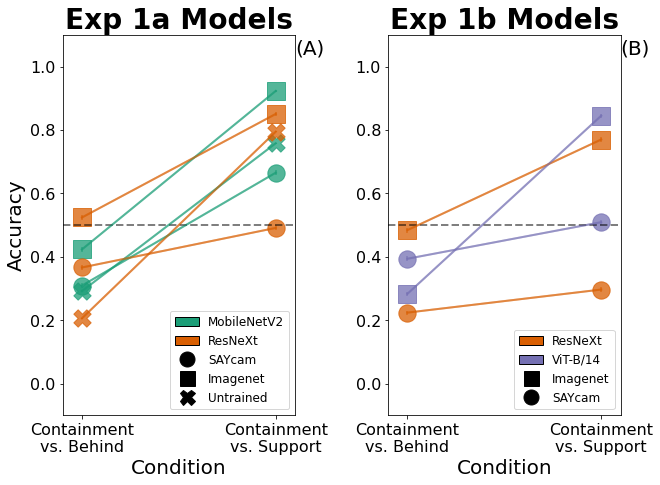

Filtering and grouping by: ['model', 'training'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'unpooled_output': True}
Filtering and grouping by: ['model', 'dino'] with filter_dict: {'training': 'DINO', 'flip': None, 'unpooled_output': True}


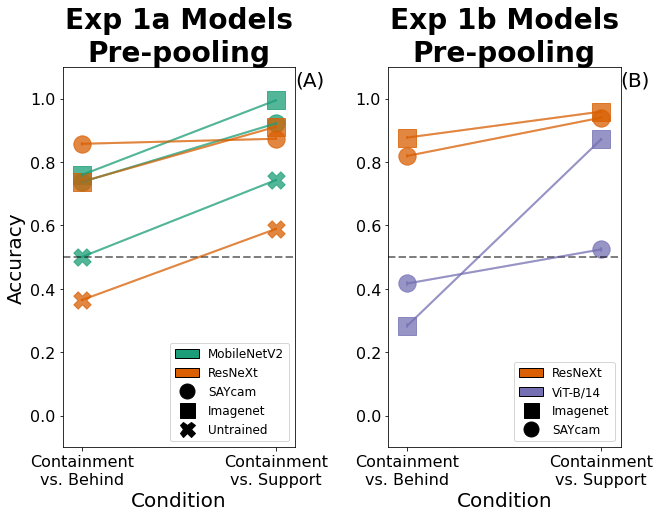

Filtering and grouping by: ['model', 'training', 'unpooled_output'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None}
Filtering and grouping by: ['model', 'dino', 'unpooled_output'] with filter_dict: {'training': 'DINO', 'flip': None}


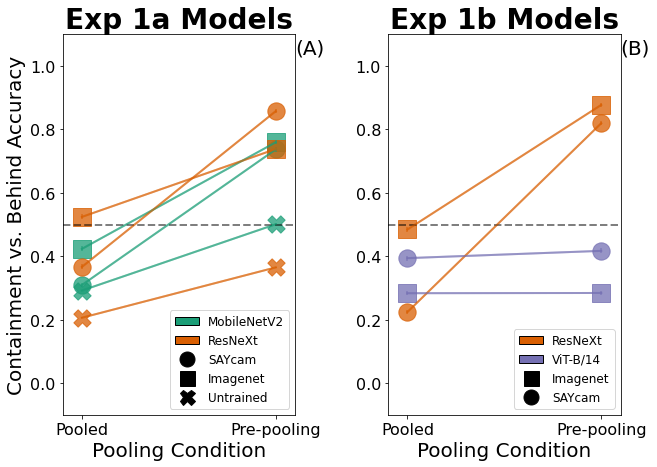

In [18]:
baseline_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, unpooled_output=False),
        marker_by='training', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Exp 1a Models')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, unpooled_output=False),
        marker_by='dino', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Exp 1b Models')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    baseline_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=-1,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Condition',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/baseline_dino_pair_plot.pdf',
)

pre_pooling_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, unpooled_output=True),
        marker_by='training', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Exp 1a Models\nPre-pooling')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, unpooled_output=True),
        marker_by='dino', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Exp 1b Models\nPre-pooling')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    pre_pooling_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=-1,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Condition',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/pre_pooled_pair_plot.pdf',
)

pre_vs_post_pooling_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None),
        marker_by='training', 
        color_by='model', 
        compare_by='unpooled_output', 
        plot_field='high_containment_vs_behind',
        title='Exp 1a Models')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None),
        marker_by='dino', 
        color_by='model', 
        compare_by='unpooled_output', 
        plot_field='high_containment_vs_behind',
        title='Exp 1b Models')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    pre_vs_post_pooling_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=-1,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Pooling Condition',
    ylabel='Containment vs. Behind Accuracy',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/pre_vs_post_pooled_pair_plot.pdf',
)

Filtering and grouping by: ['model', 'training'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'unpooled_output': False}
Filtering and grouping by: ['model', 'training'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'unpooled_output': True}


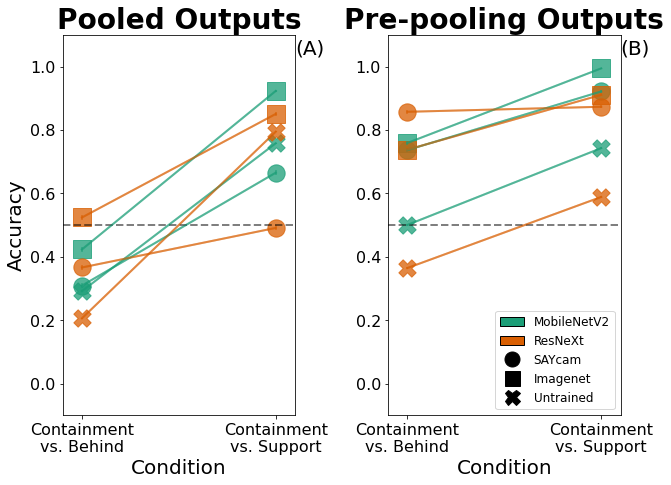

Filtering and grouping by: ['model', 'dino'] with filter_dict: {'training': 'DINO', 'flip': None, 'unpooled_output': False}
Filtering and grouping by: ['model', 'dino'] with filter_dict: {'training': 'DINO', 'flip': None, 'unpooled_output': True}


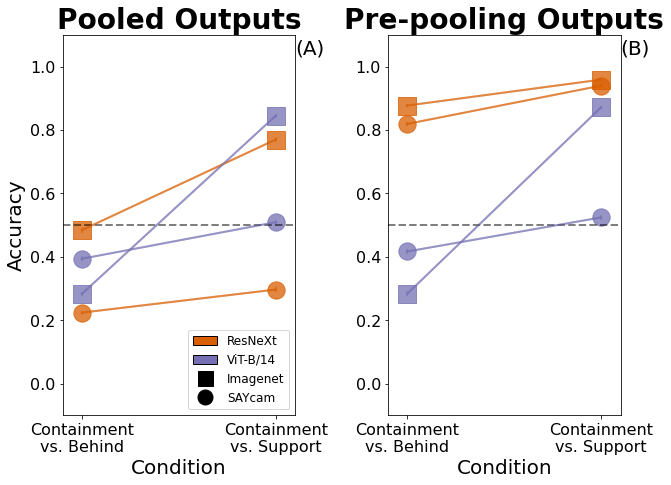

Filtering and grouping by: ['seed', 'training'] with filter_dict: {'training': 'random', 'model': 'mobilenet', 'flip': None, 'dino': None, 'unpooled_output': False}
Filtering and grouping by: ['seed', 'training'] with filter_dict: {'training': 'random', 'model': 'mobilenet', 'flip': None, 'dino': None, 'unpooled_output': True}


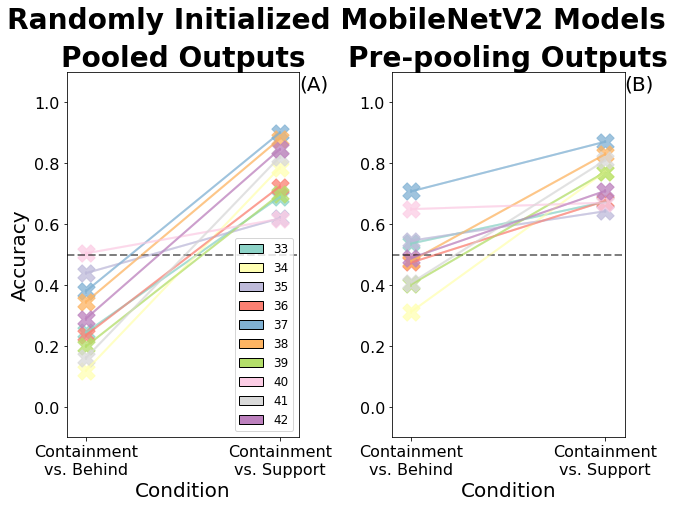

Filtering and grouping by: ['seed', 'training'] with filter_dict: {'training': 'random', 'model': 'resnext', 'flip': None, 'dino': None, 'unpooled_output': False}
Filtering and grouping by: ['seed', 'training'] with filter_dict: {'training': 'random', 'model': 'resnext', 'flip': None, 'dino': None, 'unpooled_output': True}


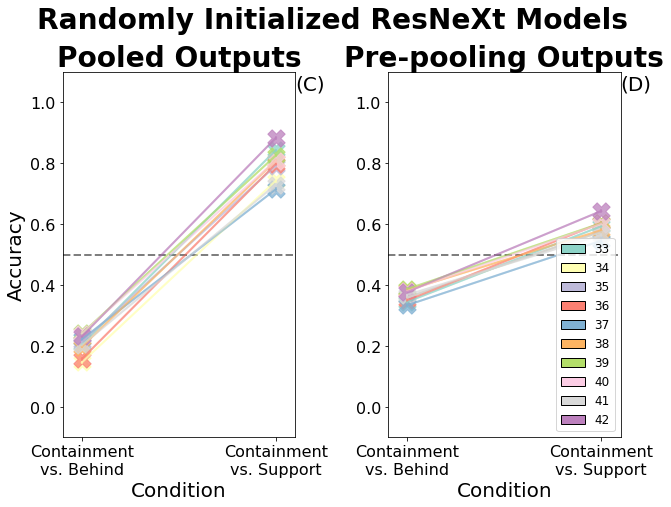

In [17]:
baseline_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, unpooled_output=False),
        marker_by='training', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pooled Outputs')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, unpooled_output=True),
        marker_by='training', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pre-pooling Outputs')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    baseline_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=1,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Condition',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/baseline_models_pair_plot.pdf',
)

dino_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, unpooled_output=False),
        marker_by='dino', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pooled Outputs')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, unpooled_output=True),
        marker_by='dino', 
        color_by='model', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pre-pooling Outputs')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    dino_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=0,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Condition',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/dino_models_pair_plot.pdf',
)

random_seed_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training='random', model='mobilenet', flip=None, dino=None, unpooled_output=False),
        marker_by='training', 
        color_by='seed', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pooled Outputs')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='random', model='mobilenet', flip=None, dino=None, unpooled_output=True),
        marker_by='training', 
        color_by='seed', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pre-pooling Outputs')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    random_seed_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=0,
    legend_loc='lower right',
    legend_marker_by=False,
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4, top=0.85),
    sup_title='Randomly Initialized MobileNetV2 Models',
    xlabel='Condition',
    save_path=f'{PAPER_FIGURE_DIR}/appendix/exp3/random_mobilenet_pair_plot.pdf',
)

random_seed_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training='random', model='resnext', flip=None, dino=None, unpooled_output=False),
        marker_by='training', 
        color_by='seed', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pooled Outputs')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='random', model='resnext', flip=None, dino=None, unpooled_output=True),
        marker_by='training', 
        color_by='seed', 
        compare_by=PLOT_FIELD, 
        plot_field=['high_containment_vs_behind', 'high_containment_vs_support'],
        title='Pre-pooling Outputs')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    random_seed_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=1,
    legend_loc='lower right',
    legend_marker_by=False,
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,top=0.85),
    sup_title='Randomly Initialized ResNeXt Models',
    xlabel='Condition',
    panel_marker_increment=2,
    save_path=f'{PAPER_FIGURE_DIR}/appendix/exp3/random_resnext_pair_plot.pdf',
)


## Well vs. mismatched stimuli

Filtering and grouping by: ['model', 'training', 'matched_behind'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'unpooled_output': False}
Filtering and grouping by: ['model', 'training', 'matched_behind'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'unpooled_output': False}


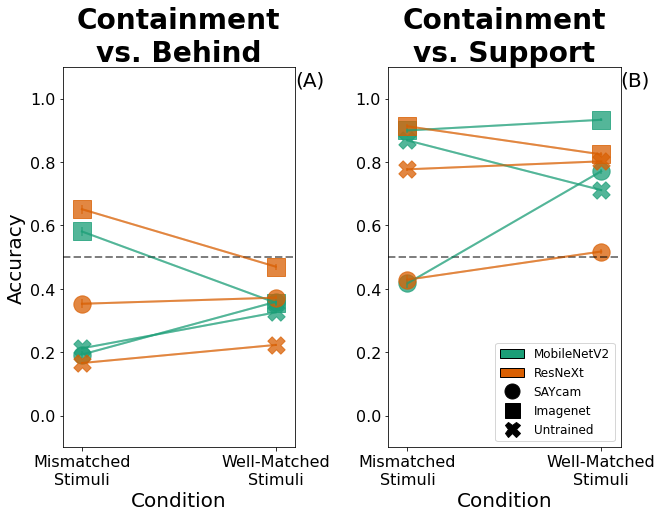

Filtering and grouping by: ['model', 'dino', 'matched_behind'] with filter_dict: {'training': 'DINO', 'flip': None, 'unpooled_output': False}
Filtering and grouping by: ['model', 'dino', 'matched_behind'] with filter_dict: {'training': 'DINO', 'flip': None, 'unpooled_output': False}


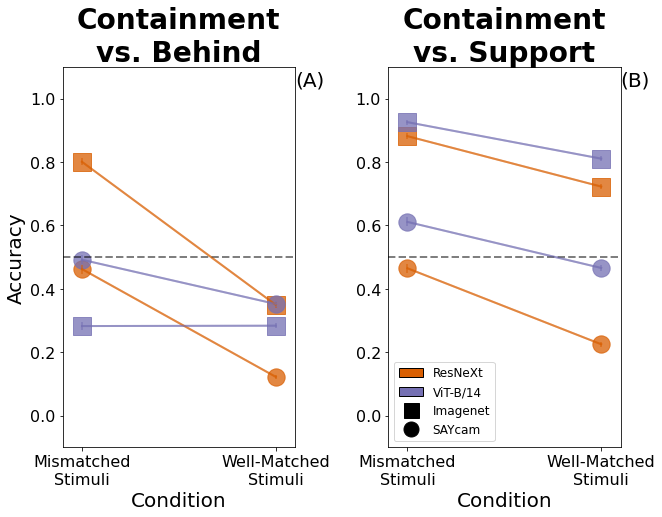

Filtering and grouping by: ['model', 'training', 'matched_behind'] with filter_dict: {'training': ['random', 'ImageNet', 'saycam(S)'], 'flip': None, 'dino': None, 'unpooled_output': False}
Filtering and grouping by: ['model', 'dino', 'matched_behind'] with filter_dict: {'training': 'DINO', 'flip': None, 'unpooled_output': False}


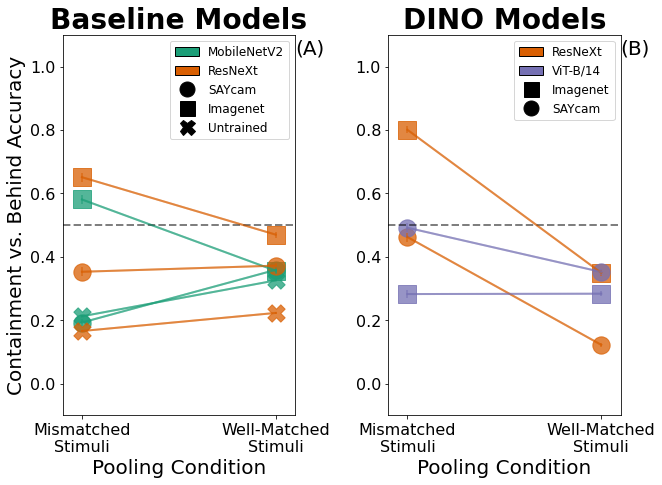

In [12]:
baseline_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, unpooled_output=False),
        marker_by='training', 
        color_by='model', 
        compare_by='matched_behind', 
        plot_field='high_containment_vs_behind',
        title='Containment\nvs. Behind')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None, unpooled_output=False),
        marker_by='training', 
        color_by='model', 
        compare_by='matched_behind', 
        plot_field='high_containment_vs_support',
        title='Containment\nvs. Support')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    baseline_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=1,
    legend_loc='lower right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Condition',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/baseline_models_matched_vs_mismatched_pair_plot.pdf',
)

dino_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, unpooled_output=False),
        marker_by='dino', 
        color_by='model', 
        compare_by='matched_behind', 
        plot_field='high_containment_vs_behind',
        title='Containment\nvs. Behind')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None, unpooled_output=False),
        marker_by='dino', 
        color_by='model', 
        compare_by='matched_behind', 
        plot_field='high_containment_vs_support',
        title='Containment\nvs. Support')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    dino_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=1,
    legend_loc='lower left',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Condition',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/dino_models_matched_vs_mismatched_pair_plot.pdf',
)


mis_vs_matched_panel_dicts = [
    defaultdict(lambda: None, dict(
        filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
            flip=None, dino=None),
        marker_by='training', 
        color_by='model', 
        compare_by='matched_behind', 
        plot_field='high_containment_vs_behind',
        title='Baseline Models')
    ),

    defaultdict(lambda: None, dict(
        filter_dict=dict(training='DINO', flip=None),
        marker_by='dino', 
        color_by='model', 
        compare_by='matched_behind', 
        plot_field='high_containment_vs_behind',
        title='DINO Models')
    ),
]

multiple_paired_scatter_plots(
    combined_df,
    mis_vs_matched_panel_dicts,
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    legend_ax_index=-1,
    legend_loc='upper right',
    title_kwargs=dict(fontweight='bold'),
    text_kwargs=dict(fontsize=20),
    subplot_adjust_params=dict(wspace=0.4,),
    xlabel='Pooling Condition',
    ylabel='Containment vs. Behind Accuracy',
    save_path=f'{PAPER_FIGURE_DIR}/exp3/mis_vs_matched_pair_plot.pdf',
)

In [13]:
import itertools
from scipy.stats import ttest_rel

TEST_FIELD = 'training'

filter_dict = dict(training=['ImageNet', 'saycam(S)'], flip=None, dino=None, unpooled_output=False, n_target_types=[1, 2])
for k, v in FILTER_DICT_DEFAULT_VALUES.items():
    if k not in filter_dict and k in combined_df.columns:
        filter_dict[k] = v

baseline_df = filter_and_group(combined_df, filter_dict, [])

test_field_values = baseline_df[TEST_FIELD].unique()
accuracies_by_dino_dataset = defaultdict(list)

for model, n_target_types in itertools.product(baseline_df.model.unique(), baseline_df.n_target_types.unique()):
    row_filter = (baseline_df.model == model) & (baseline_df.n_target_types == n_target_types) 
    mini_df = baseline_df[row_filter]

    if len(mini_df) != (2 * baseline_df.example_index.unique().shape[0]):
        print(f'WARNING: {model} {n_target_types} has unexpected shape: {mini_df.shape}')
        break

    mini_groupby_df = mini_df.groupby(TEST_FIELD).high_containment_vs_behind.mean()

    for test_field_value in test_field_values:
        accuracies_by_dino_dataset[test_field_value].append(mini_groupby_df[test_field_value])


ttest_rel(accuracies_by_dino_dataset[test_field_values[0]], accuracies_by_dino_dataset[test_field_values[1]])


Ttest_relResult(statistic=-6.217877094972067, pvalue=0.10151610207566003)

In [14]:
import itertools
from scipy.stats import ttest_rel

TEST_FIELD = 'dino'

filter_dict = dict(training='DINO', flip=None, unpooled_output=False, n_target_types=[1, 2])
for k, v in FILTER_DICT_DEFAULT_VALUES.items():
    if k not in filter_dict and k in combined_df.columns:
        filter_dict[k] = v

baseline_df = filter_and_group(combined_df, filter_dict, [])

test_field_values = baseline_df[TEST_FIELD].unique()
accuracies_by_dino_dataset = defaultdict(list)

for model, n_target_types in itertools.product(baseline_df.model.unique(), baseline_df.n_target_types.unique()):
    row_filter = (baseline_df.model == model) & (baseline_df.n_target_types == n_target_types) 
    mini_df = baseline_df[row_filter]

    if len(mini_df) != (2 * baseline_df.example_index.unique().shape[0]):
        print(f'WARNING: {model} {n_target_types} has unexpected shape: {mini_df.shape}')
        break

    mini_groupby_df = mini_df.groupby(TEST_FIELD).high_containment_vs_behind.mean()

    for test_field_value in test_field_values:
        accuracies_by_dino_dataset[test_field_value].append(mini_groupby_df[test_field_value])


ttest_rel(accuracies_by_dino_dataset[test_field_values[0]], accuracies_by_dino_dataset[test_field_values[1]])


Ttest_relResult(statistic=-0.40355497037524685, pvalue=0.7558135077973431)

In [15]:
def sem_agg(x):
    return np.std(x) / np.sqrt(len(x))

combined_df[(combined_df.model == 'mobilenet') & (combined_df.unpooled_output == False) & (combined_df.training == 'random')].groupby('reference_object')[['high_containment_vs_behind', 'high_containment_vs_support']].agg([np.mean, sem_agg])

high_containment_vs_behind            \
                                          mean   sem_agg   
reference_object                                           
Basket                                0.344531  0.004696   
CardboardBoxNoFlaps                   0.266211  0.004368   
ShortBoxNoFlaps                       0.304883  0.004549   
WoodenBasket                          0.251758  0.004289   

                    high_containment_vs_support            
                                           mean   sem_agg  
reference_object                                           
Basket                                 0.703223  0.004515  
CardboardBoxNoFlaps                    0.878223  0.003232  
ShortBoxNoFlaps                        0.891309  0.003076  
WoodenBasket                           0.560254  0.004905

TypeError: unhashable type: 'dict'

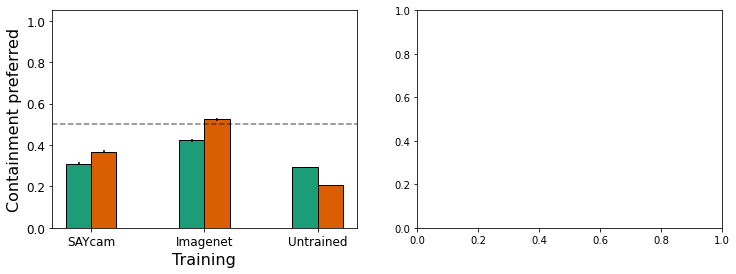

In [16]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None, unpooled_output=False),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.3,),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None, unpooled_output=True),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'Baseline models, unpooled',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.3,),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None, unpooled_output=False),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='matched_behind',
    hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_behind',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Mismatched stimuli', 'Well-matched stimuli'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'Baseline models, mis/matched stimuli',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.3,),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None, unpooled_output=True),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='matched_behind',
    hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_behind',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Mismatched stimuli', 'Well-matched stimuli'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'Baseline models, unpooled, mis/matched stimuli',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.3,),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )


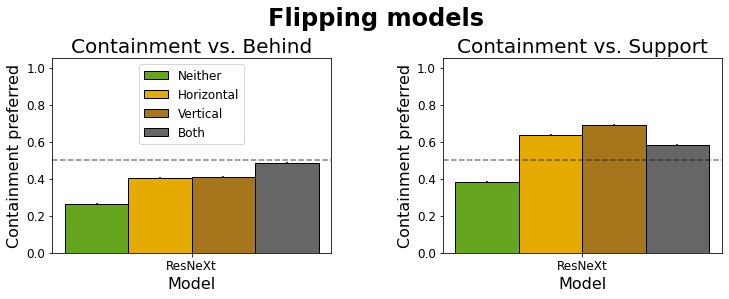

In [18]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='model', 
    color_bars_by='flip', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    # hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'Flipping models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper center',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.4,),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

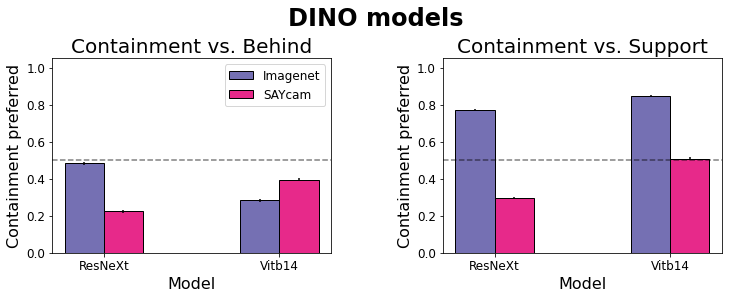

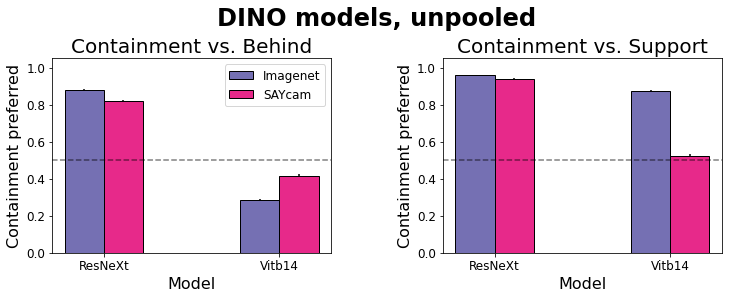

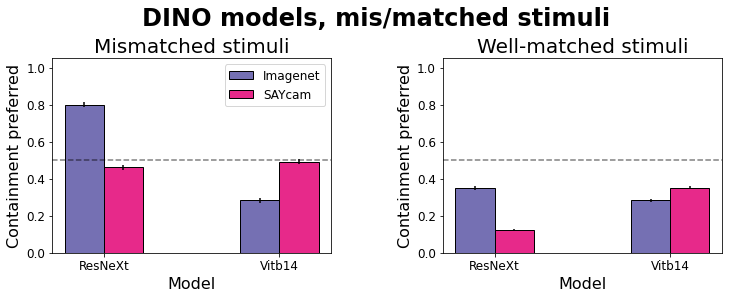

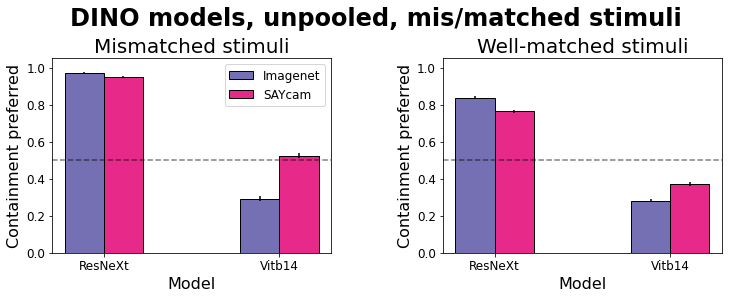

In [25]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', unpooled_output=False),
    group_bars_by='model', 
    color_bars_by='dino', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    # hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.4,),
    # save_path='baseline_horizontal_references.png',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )



multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', unpooled_output=True),
    group_bars_by='model', 
    color_bars_by='dino', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    # hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'DINO models, unpooled',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.4,),
    # save_path='baseline_horizontal_references.png',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', unpooled_output=False),
    group_bars_by='model', 
    color_bars_by='dino', 
    panel_by='matched_behind',
    # hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_behind',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Mismatched stimuli', 'Well-matched stimuli'],
    sup_title=f'DINO models, mis/matched stimuli',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.4,),
    # save_path='baseline_horizontal_references.png',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', unpooled_output=True),
    group_bars_by='model', 
    color_bars_by='dino', 
    panel_by='matched_behind',
    # hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_behind',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Mismatched stimuli', 'Well-matched stimuli'],
    sup_title=f'DINO models, unpooled, mis/matched stimuli',
    legend_ax_index=0,
    legend_loc='upper right',
    ylabel=['Containment preferred', 'Containment preferred'],
    ylabel_per_ax=True,
    subplot_adjust_params=dict(top=0.8, wspace=0.4,),
    # save_path='baseline_horizontal_references.png',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
filter_and_group(combined_df, dict(training='DINO'), ['model', 'dino']).correct.mean()

In [ ]:
combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']

In [ ]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='reference_object', 
    color_bars_by='flip', 
    relevant_fields=('containment_high_containment_cos', 'correct', 'cos_ratio'))

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='reference_object',
    color_bars_by='flip', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    # hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 8),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'Flipping models by reference object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper center',
    ylabel='Containment preferred',
    subplot_adjust_params=dict(hspace=0.35, top=0.9),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='reference_object', 
    color_bars_by='dino', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    # hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 8),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'DINO models by reference object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper center',
    ylabel='Containment preferred',
    subplot_adjust_params=dict(hspace=0.35, top=0.9),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    # hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 8),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper center',
    ylabel='Containment preferred',
    subplot_adjust_params=dict(hspace=0.35, top=0.9),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by=['high_containment_vs_behind', 'high_containment_vs_support'],
    # hatch_bars_by='n_target_types',
    # plot_field=,
    compute_std=True,
    # plot style arguments
    figsize = (12, 8),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Containment vs. Behind', 'Containment vs. Support'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title=f'DINO models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper center',
    ylabel='Containment preferred',
    subplot_adjust_params=dict(hspace=0.35, top=0.9),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
n_panels = len(combined_df.reference_object.unique())

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='reference_object',
    # hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_behind',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4 * n_panels),
    layout = (n_panels, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Wicker Basket', 'Cardboard Box', 'Wooden Basket'],
    # panel_titles=,
    sup_title=f'Flipping models by reference X target objects{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['High containment vs. behind'] * n_panels,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='reference_object',
    # hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_support',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4 * n_panels),
    layout = (n_panels, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Wicker Basket', 'Cardboard Box', 'Wooden Basket'],
    # panel_titles=,
    sup_title=f'Flipping models by reference X target objects{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=0,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['High containment vs. support'] * n_panels,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
plot_field = 'cos_diff'
n_panels = len(combined_df.reference_object.unique())


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='reference_object',
    # hatch_bars_by='n_target_types',
    plot_field=plot_field,
    compute_std=True,
    # plot style arguments
    figsize = (12, 4 * n_panels),
    layout = (n_panels, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=,
    sup_title=f'Flipping models by reference X target objects{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=[DEFAULT_YALBELS[plot_field]] * n_panels,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
n_panels = len(combined_df.reference_object.unique())

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by='reference_object',
    # hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_behind',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4 * n_panels),
    layout = (n_panels, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Wicker Basket', 'Cardboard Box', 'Wooden Basket'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by reference X target objects{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['High containment vs. behind'] * n_panels,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

n_panels = len(combined_df.reference_object.unique())

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by='reference_object',
    # hatch_bars_by='n_target_types',
    plot_field='high_containment_vs_support',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4 * n_panels),
    layout = (n_panels, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Wicker Basket', 'Cardboard Box', 'Wooden Basket'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by reference X target objects{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['High containment vs. support'] * n_panels,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
plot_field = 'cos_diff'
n_panels = len(combined_df.reference_object.unique())


multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by='reference_object',
    # hatch_bars_by='n_target_types',
    plot_field=plot_field,
    compute_std=True,
    # plot style arguments
    figsize = (12, 4 * n_panels),
    layout = (n_panels, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Wicker Basket', 'Cardboard Box', 'Wooden Basket'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by reference X target objects{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=[DEFAULT_YALBELS[plot_field]] * n_panels,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by=['correct', 'behind_similar', 'far_behind_similar', 'support_similar'],
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Flipping models split by most similar X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='reference_object', 
    color_bars_by='flip', 
    panel_by=['correct', 'behind_similar', 'far_behind_similar', 'support_similar'],
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (8, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Most similar X reference object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by=['correct', 'behind_similar', 'far_behind_similar', 'support_similar'],
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models split by most similar X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [ ]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='reference_object', 
    color_bars_by='dino', 
    panel_by=['correct', 'behind_similar', 'far_behind_similar', 'support_similar'],
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (8, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Most similar X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )